# Research Project - Uncertainty Quantification
- **Author** : Amine Rannen-Triki
- **Date**: 15/07/2025
- Imperial College London - Department of Mathematics
- MS Machine Learning and Data Science (MLDS)
- Notebook 02 - Phase 2 - Scalability and approximation (classification with ConfidNet and $L_{new}$)



#0. Drive mounting and model download

Use this function and cells to download the pre-trained model from google Drive and are using this notebook on Collab.
Otherwise, make sure to upload the trained models in folder named `models`

In [ ]:
from google.colab import drive
import shutil
from pathlib import Path

def mount_google_drive():
    """Mounts Google Drive to the Colab environment."""
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully.")
    except Exception as e:
        print(f"❌ An error occurred while mounting Google Drive: {e}")

def upload_models_to_drive(source_folder=Path("models"), destination_folder=Path("/content/drive/MyDrive/colab_model_backups")):
    """
    Uploads the models folder from Colab to a specified folder in Google Drive.

    Args:
        source_folder (Path): The path to the folder containing models in Colab.
        destination_folder (Path): The path to the desired destination folder in Google Drive.
    """
    destination_path = destination_folder / source_folder.name
    # Create the destination folder in Drive if it doesn't exist
    destination_folder.mkdir(exist_ok=True)

    try:
        # Use shutil.copytree to copy the folder and its contents
        # Use dirs_exist_ok=True to allow overwriting existing files/folders
        shutil.copytree(source_folder, destination_path, dirs_exist_ok=True)
        print(f"✅ Successfully copied '{source_folder}' to '{destination_path}'")
    except FileExistsError:
        # This exception is less likely with dirs_exist_ok=True, but good to keep as a fallback
        print(f"ℹ️ Destination folder '{destination_path}' already exists. Models were likely updated.")
    except Exception as e:
        print(f"❌ An error occurred while copying the models folder to Google Drive: {e}")

def download_models_from_drive(source_folder_drive=Path("/content/drive/MyDrive/colab_model_backups/models"), destination_folder_colab=Path(".")):
    """
    Downloads the models folder from Google Drive to a specified folder in Colab.

    Args:
        source_folder_drive (Path): The path to the models folder in Google Drive.
        destination_folder_colab (Path): The path to the desired destination folder in Colab.
    """
    destination_path = destination_folder_colab / source_folder_drive.name
    # Ensure the destination folder in Colab exists
    destination_folder_colab.mkdir(exist_ok=True)

    try:
        # Use shutil.copytree to copy the folder and its contents
        # Use dirs_exist_ok=True to allow overwriting existing files/folders
        shutil.copytree(source_folder_drive, destination_path, dirs_exist_ok=True)
        print(f"✅ Successfully copied '{source_folder_drive}' to '{destination_path}'")
    except FileExistsError:
         # This exception is less likely with dirs_exist_ok=True, but good to keep as a fallback
        print(f"ℹ️ Destination folder '{destination_path}' already exists. Models were likely updated.")
    except Exception as e:
        print(f"❌ An error occurred while copying the models folder from Google Drive: {e}")

mount_google_drive()

#uncomment to download saved models
download_models_from_drive(source_folder_drive=Path("/content/drive/MyDrive/colab_model_backups/notebook_2"))


Mounted at /content/drive
✅ Google Drive mounted successfully.
✅ Successfully copied '/content/drive/MyDrive/colab_model_backups/notebook_2' to 'notebook_2'


# 1. Preparation

## 1.1 Configuration and setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================================================================
# 1. Configuration & Setup
# ==========================================================================================

# Ensure the 'models' directory exists for saving weights
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10

EPOCHS_PREDICTOR = 10
LR_PREDICTOR = 0.01

EPOCHS_CONVICTION = 20
LR_CONVICTION = 0.001

EPOCHS_FINETUNE = 20
LR_FINETUNE = 1e-5

FINETUNE = 1e-5


# --- Hyperparameters ---
# 1. Define Experiment Configuration
config = {
    'device': DEVICE,
    'num_classes': NUM_CLASSES,
    'lr_finetune': LR_FINETUNE,
    'epochs_finetune': EPOCHS_FINETUNE,
    'batch_size': BATCH_SIZE,
}

## 1.2. Models definition

In [ ]:
# ==========================================================================================
# 2. Model Definitions
# Define different architectures for :
#     - the predictor (f)
#     - conviction (w)
#     - JointModel (f+w)
# ==========================================================================================


class VGGStylePredictor(nn.Module):
    """A VGG-style classifier that also exposes its feature extractor and feature dimension."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Simplified for a flat feature vector

        # This is the dimension of the features right before the classifier head
        self.feature_dim = 512

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        """Full forward pass for prediction."""
        features = self.get_features(x)
        return self.classifier(features)

    def get_features(self, x):
        """Extracts features from the backbone."""
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class SimpleConvPredictor(nn.Module):
    """A simpler convolutional predictor to demonstrate modularity."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Feature dimension for this model
        self.feature_dim = 64

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.get_features(x)
        return self.classifier(features)

    def get_features(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class MLPConvictionNet(nn.Module):
    """A flexible MLP-based conviction network."""
    def __init__(self, input_dim):
        super().__init__()
        self.confid_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output confidence between 0 and 1
        )

    def forward(self, x):
        return self.confid_layers(x)
# Create a combined model for fine-tuning that takes images as input
# This model contains both the predictor's feature extraction and the conviction network

class JointTrainingModel(nn.Module):
    """A model that wraps predictor and conviction net for joint training,
       outputting both predictor logits and conviction scores."""
    def __init__(self, predictor_model, conviction_network):
        super().__init__()
        self.predictor_model = predictor_model
        self.conviction_network = conviction_network

    def forward(self, x):
        # The joint model uses its own, internally updating feature extractor
        features = self.predictor_model.get_features(x)
        predictor_outputs = self.predictor_model.classifier(features)
        confidence = self.conviction_network(features)
        return predictor_outputs, confidence


## 1.3. Custom loss functions

In [ ]:
# ==========================================================================================
# 3. Custom Loss Functions
# ==========================================================================================

class WeightedSumLoss(nn.Module):
    """Custom loss function for fine-tuning the combined model."""
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none') # Use reduction='none' to get element-wise loss

    def forward(self, predictions, targets, confidence_weights):
        # predictions are the confidence scores from the conviction network
        # targets are the TCP values from the predictor

        # Calculate the squared error for each prediction
        squared_errors = self.mse(predictions, targets)

        # Calculate the confidence weights: higher weight for lower confidence
        # Add a small epsilon to avoid division by zero if confidence is exactly 0
        # Calculate the weighted squared error
        weighted_squared_errors = squared_errors * confidence_weights

        # Calculate the weighted mean squared error, adding a small epsilon for stability
        weighted_mse = torch.sum(weighted_squared_errors) / (torch.sum(confidence_weights) + 1e-8)

        # The loss is the weighted MSE
        loss = weighted_mse

        return loss

class L_new_Loss(nn.Module):
    """
    Implementation of the L_new loss for joint training using EMA algorithm.
    L_new = sum(conviction * predictor_loss) / sum(conviction)
    """
    def __init__(self, initial_denominator=1.0, alpha=0.99):
        super().__init__()
        # Use CrossEntropyLoss with no reduction to get per-sample loss
        self.predictor_loss_fn = nn.CrossEntropyLoss(reduction='none')
        # Register the running denominator as a buffer to track it
        self.register_buffer('running_denominator', torch.tensor(initial_denominator, dtype=torch.float32))
        self.alpha = alpha

    def forward(self, predictor_outputs, labels, conviction_scores):
        # 1. Calculate the predictor's per-sample loss
        per_sample_predictor_loss = self.predictor_loss_fn(predictor_outputs, labels)

        # 2. Calculate the numerator: conviction-weighted predictor loss
        numerator = torch.sum(conviction_scores.squeeze() * per_sample_predictor_loss)

        # 3. Update the running average of the denominator (approximating the global sum)
        # We use a detached version of the batch sum to prevent this update from affecting gradients
        current_batch_denominator_sum = torch.sum(conviction_scores).detach()
        self.running_denominator = self.alpha * self.running_denominator + (1 - self.alpha) * current_batch_denominator_sum

        # 4. Calculate the final loss
        # We use the updated running denominator. Use .detach() on the denominator
        # during the division to ensure the gradient only flows through the numerator.
        final_loss = numerator / self.running_denominator.detach()

        return final_loss

class L_new_SamplingLoss(nn.Module):
    """
    Implementation of the L_new loss for joint training using Sampling approximation.
    L_new = sum(conviction * predictor_loss) / sum(conviction) (approximated by sampling)
    """
    def __init__(self, train_dataset, sampling_percentage=0.1, sampling_batch_size=None):
        super().__init__()
        # Use CrossEntropyLoss with no reduction to get per-sample loss
        self.predictor_loss_fn = nn.CrossEntropyLoss(reduction='none')
        self.train_dataset = train_dataset
        self.sampling_percentage = sampling_percentage
        self.sampling_batch_size = sampling_batch_size

        if sampling_batch_size is None and sampling_percentage is None:
            raise ValueError("Either sampling_percentage or sampling_batch_size must be provided.")
        if sampling_batch_size is not None and sampling_percentage is not None:
             print("Warning: Both sampling_percentage and sampling_batch_size are provided. Using sampling_batch_size.")
             self.sampling_percentage = None # Prioritize batch size

    def forward(self, predictor_outputs, labels, conviction_scores, joint_model):
        # 1. Calculate the predictor's per-sample loss for the current batch
        per_sample_predictor_loss = self.predictor_loss_fn(predictor_outputs, labels)

        # 2. Calculate the numerator: conviction-weighted predictor loss for the current batch
        numerator = torch.sum(conviction_scores.squeeze() * per_sample_predictor_loss)

        # 3. Sample a subset of the training dataset to approximate the denominator sum
        dataset_size = len(self.train_dataset)
        if self.sampling_batch_size is not None:
            num_samples = min(self.sampling_batch_size, dataset_size)
        else:
            num_samples = int(dataset_size * self.sampling_percentage)

        # Ensure num_samples is at least 1
        num_samples = max(1, num_samples)

        # Randomly sample indices
        sampled_indices = torch.randperm(dataset_size)[:num_samples]

        # Create a DataLoader for the sampled subset
        sampled_dataset = torch.utils.data.Subset(self.train_dataset, sampled_indices)
        sampled_loader = torch.utils.data.DataLoader(
            sampled_dataset,
            batch_size=num_samples,
            shuffle=False,
            num_workers=0
        )

        # Calculate the sum of conviction scores for the sampled subset
        original_mode = joint_model.training
        joint_model.eval()
        original_device = next(joint_model.parameters()).device

        sum_of_sampled_convictions = 0.0
        with torch.no_grad():
            for sampled_inputs, _ in sampled_loader:
                 sampled_inputs = sampled_inputs.to(original_device)
                 # Use the joint model's internal predictor to get features
                 features = joint_model.predictor_model.get_features(sampled_inputs)
                 # Use the joint model's internal conviction network
                 sampled_conviction_scores = joint_model.conviction_network(features).squeeze()
                 sum_of_sampled_convictions += torch.sum(sampled_conviction_scores).item()
        # Restore original model state
        joint_model.train(original_mode)


        # 4. Calculate the final loss using the sampled denominator
        # Add a small epsilon to the denominator to prevent division by zero
        denominator = sum_of_sampled_convictions + 1e-8
        final_loss = numerator / denominator

        return final_loss

## 1.4. Data, Training, and Evaluation Utilities

In [ ]:
# ==========================================================================================
# 4. Data, Training, and Evaluation Utilities
# ==========================================================================================

# ==========================================================================================
# A utility function to prepare the CIFAR-10 dataset.
# ==========================================================================================

def get_cifar10_loaders(batch_size=128):
    """Returns train and test DataLoaders for CIFAR-10."""
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader



# ==========================================================================================
# Training & Preparation Utilities
# Reusable functions for each stage of the process.
# ==========================================================================================

def train_predictor(model, train_loader, epochs, lr, device, model_save_path):
    """Train the base predictor model (Stage 1)."""
    print(f"--- Stage 1: Training Predictor ({model.__class__.__name__}) ---")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.3f}")
                running_loss = 0.0

    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Predictor model saved to {model_save_path}\n")

def prepare_conviction_data(predictor, data_loader, device):
    """
    Extracts features and calculates True Class Probability (TCP) targets
    to create a new dataset for training the conviction network.
    """
    print("--- Preparing data for Conviction Network ---")
    predictor.to(device)
    predictor.eval() # Freeze the predictor

    all_features = []
    all_tcp_targets = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Extract features from the frozen predictor
            features = predictor.get_features(inputs)

            # Get full output to calculate TCP
            outputs = predictor.classifier(features)
            softmax_probs = F.softmax(outputs, dim=1)
            tcp_targets = softmax_probs.gather(1, labels.unsqueeze(1)).squeeze()

            all_features.append(features.cpu())
            all_tcp_targets.append(tcp_targets.cpu())

    dataset = torch.utils.data.TensorDataset(torch.cat(all_features), torch.cat(all_tcp_targets))
    loader = torch.utils.data.DataLoader(dataset, batch_size=data_loader.batch_size, shuffle=True)
    print("✅ Conviction data prepared.\n")
    return loader

def train_conviction_network(model, train_loader, epochs, lr, device, model_save_path, stage_name="", loss_fn=nn.MSELoss()):
    """Train a model (conviction net or combined model) using MSE loss against TCP targets."""
    print(f"--- {stage_name} ---")
    model.to(device)
    criterion = loss_fn
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            predictions = model(features).squeeze()

            # Check if the loss function is WeightedSumLoss
            #if isinstance(criterion, WeightedSumLoss):
            #    loss = criterion(predictions, targets, predictions)
            #else:
            loss = criterion(predictions, targets)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
                running_loss = 0.0

    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model saved to {model_save_path}\n")


## 1.5. Experiment Runner

In [ ]:
# ==========================================================================================
# 5. Experiment Runner
# ==========================================================================================


def run_experiment(loss_name, config, base_paths, loaders, verbose=False):
    """
    Runs the full fine-tuning and evaluation experiment for a given loss function.
    Checks if the fine-tuned model already exists and loads it if found.
    """
    print(f"\n{'='*30}\n💥 STARTING EXPERIMENT: {loss_name} 💥\n{'='*30}")

    # --- Unpack config, paths, and loaders ---
    DEVICE = config['device']
    NUM_CLASSES = config['num_classes']
    LR_FINETUNE = config['lr_finetune']
    EPOCHS_FINETUNE = config['epochs_finetune']

    predictor_path = base_paths['predictor']
    conviction_path = base_paths['conviction']
    # Save the final model with a unique name based on the loss used
    finetuned_path = Path(f"models/finetuned_model_{loss_name}.pth")

    train_loader, test_loader = loaders

    # --- Model Initialization ---
    # start with the same pre-trained predictor and conviction network for a fair comparison
    predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))

    conviction_net = MLPConvictionNet(input_dim=predictor.feature_dim)
    conviction_net.load_state_dict(torch.load(conviction_path, map_location=DEVICE))

    # Use the JointTrainingModel for both experiments for consistency
    #         predictor_outputs = self.predictor_model.classifier(features)
    joint_model = JointTrainingModel(predictor, conviction_net).to(DEVICE)
    optimizer = optim.Adam(joint_model.parameters(), lr=LR_FINETUNE)

    # Create a SEPARATE, FROZEN predictor just for generating targets
    #target_predictor = VGGStylePredictor(num_classes=NUM_CLASSES).to(DEVICE)
    #target_predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
    #target_predictor.eval().to(DEVICE) # Set to evaluation mode once. It will not be trained.


    # --- Select Loss Function & Prepare for Loop ---
    if loss_name == 'MSE':
        criterion = nn.MSELoss()
    elif loss_name == 'L_new':
        criterion = L_new_Loss().to(DEVICE)
    else:
        raise ValueError(f"Unsupported loss function: {loss_name}")

    # --- Check if fine-tuned model already exists ---
    if finetuned_path.exists():
        print(f"--- Stage 3 (Fine-Tuning): Found existing fine-tuned model at {finetuned_path}, loading weights. ---")
        joint_model.load_state_dict(torch.load(finetuned_path, map_location=DEVICE))
    else:
        print(f"--- Stage 3 (Fine-Tuning): Using {loss_name} loss ---")
        # --- Fine-Tuning Loop ---
        for epoch in range(EPOCHS_FINETUNE):
            joint_model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                predictor_outputs, conviction_scores = joint_model(inputs)

                # Calculate loss based on the chosen method
                if loss_name == 'MSE':
                    with torch.no_grad():
                      # For the MSE case, we need a frozen, original predictor to generate TCP targets
                      #target_predictor = VGGStylePredictor(num_classes=NUM_CLASSES).to(DEVICE)
                      #target_predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
                      #target_predictor.eval().to(DEVICE)
                      #original_outputs = target_predictor(inputs)
                      original_outputs = predictor(inputs)
                      softmax_outputs = F.softmax(original_outputs, dim=1)
                      tcp_targets = softmax_outputs.gather(1, labels.unsqueeze(1)).squeeze()
                    predicted_confidence = conviction_scores.squeeze()
                    loss = criterion(predicted_confidence, tcp_targets)

                    #loss = criterion(conviction_scores.squeeze(), tcp_targets)

                else:  # L_new case
                    features = predictor.get_features(inputs)
                    predictor_outputs = predictor.classifier(features)
                    conviction_scores = conviction_net(features)
                    # Get predicted confidence from the fine-tuned model
                    # This automatically uses the potentially updated feature extractor within combined_model
                    #predicted_confidence = fine_tune_combined_model(inputs).squeeze()
                    # Calculate loss
                    #loss = fine_tune_criterion(predicted_confidence, tcp_targets)
                    #loss = fine_tune_criterion(predicted_confidence, tcp_targets, predicted_confidence) #MSE Case
                    #loss = fine_tune_criterion(predictor_outputs, labels, conviction_scores) #Lnew case

                    loss = criterion(predictor_outputs, labels, conviction_scores)

                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if i % 100 == 99:
                    print(f'Epoch [{epoch + 1}/{EPOCHS_FINETUNE}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                    running_loss = 0.0

        # --- Save Model after training ---
        torch.save(joint_model.state_dict(), finetuned_path)
        print(f"✅ Fine-tuned model ({loss_name}) saved to {finetuned_path}\n")


    # --- Evaluate ---
    # results, confidences, correctness = evaluate_joint_model(
    #     joint_model=joint_model,
    #     test_loader=test_loader,
    #     device=DEVICE,
    #     model_name=loss_name
    # )
    # Load the original predictor for calculating accuracy
    #final_predictor = SimpleConvPredictor(num_classes=NUM_CLASSES) # Use the same class as trained
    final_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    # Load the state dict for the predictor part from the saved combined model state dict
    combined_model_state_dict = torch.load(finetuned_path, map_location=DEVICE)
    predictor_state_dict = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict.items() if 'predictor_model.' in k}
    final_predictor.load_state_dict(predictor_state_dict)
    final_predictor.eval().to(DEVICE) # Ensure predictor is on the correct device for evaluation


    # Load the fine-tuned conviction network directly
    final_conviction_net = MLPConvictionNet(input_dim=final_predictor.feature_dim)
    # Extract the state dict for the conviction network part
    conviction_net_state_dict = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict.items() if 'conviction_network.' in k}
    final_conviction_net.load_state_dict(conviction_net_state_dict)
    final_conviction_net.eval().to(DEVICE) # Ensure conviction net is on the correct device


    results, confidences, correctness = evaluate_conviction_system(
        predictor=final_predictor,
        conviction_model=final_conviction_net, # Pass the fine-tuned conviction net
        test_loader=test_loader,
        device=DEVICE,
        verbose=verbose
    )


    return results, confidences, correctness

## 1.6 Evaluation and visualisation

In [ ]:


# ==========================================================================================
## 4. Evaluation Utilities
# Functions to compute metrics and visualize results.
# ==========================================================================================

def evaluate_conviction_system(predictor, conviction_model, test_loader, device, verbose=False):
    """Evaluates the conviction system on the test set."""
    if verbose:
      print("--- Evaluating Conviction System ---")
    predictor.to(device).eval()
    conviction_model.to(device).eval()

    is_correct_list = []
    predicted_confidence_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get base model predictions to check correctness
            features = predictor.get_features(inputs)
            outputs = predictor.classifier(features)
            _, predicted_classes = torch.max(outputs.data, 1)
            is_correct_list.extend((predicted_classes == labels).cpu().numpy())

            # Get conviction network's confidence prediction
            confidence = conviction_model(features).squeeze()
            predicted_confidence_list.extend(confidence.cpu().numpy())

    is_correct_list = np.array(is_correct_list)
    predicted_confidence_list = np.array(predicted_confidence_list)

    # --- Calculate Metrics ---
    # Labels for failure prediction: 1 for incorrect, 0 for correct
    failure_labels = 1 - is_correct_list
    # Scores for failure prediction: lower confidence = higher chance of failure
    failure_scores = 1 - predicted_confidence_list

    results = {
        "accuracy": np.mean(is_correct_list) * 100,
        "auroc": roc_auc_score(failure_labels, failure_scores),
        "auprc": average_precision_score(failure_labels, failure_scores),
        "mean_conf_correct": np.mean(predicted_confidence_list[is_correct_list == 1]),
        "mean_conf_incorrect": np.mean(predicted_confidence_list[is_correct_list == 0]),
    }
    if verbose :
      print(f"Base Predictor Accuracy: {results['accuracy']:.2f}%")
      print(f"AUROC for Failure Prediction: {results['auroc']:.4f}")
      print(f"AUPRC for Failure Prediction: {results['auprc']:.4f}")
      print(f"Mean Confidence (Correct): {results['mean_conf_correct']:.4f}")
      print(f"Mean Confidence (Incorrect): {results['mean_conf_incorrect']:.4f}")

    return results, predicted_confidence_list, is_correct_list

def plot_confidence_distribution(confidences, correctness, title="Confidence Distribution"):
    """Plots the confidence distributions for correct vs. incorrect predictions."""

    predicted_confidence_list = np.array(confidences)
    is_correct_list = np.array(correctness)

    # Separate confidence scores for correct and incorrect predictions
    predicted_confidence_correct = predicted_confidence_list[is_correct_list == 1]
    predicted_confidence_incorrect = predicted_confidence_list[is_correct_list == 0]

    mean_conf_correct = np.mean(predicted_confidence_correct)
    median_conf_correct = np.median(predicted_confidence_correct)
    std_conf_correct = np.std(predicted_confidence_correct)

    mean_conf_incorrect = np.mean(predicted_confidence_incorrect)
    median_conf_incorrect = np.median(predicted_confidence_incorrect)
    std_conf_incorrect = np.std(predicted_confidence_incorrect)
    # Set plot style
    sns.set_style("whitegrid")

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot histograms for correct and incorrect predictions
    sns.histplot(predicted_confidence_correct, color='skyblue', label='Correct Predictions', kde=True, stat='density', common_norm=False)
    sns.histplot(predicted_confidence_incorrect, color='salmon', label='Incorrect Predictions', kde=True, stat='density', common_norm=False)

    # Add labels and title
    plt.xlabel("Predicted Confidence")
    plt.ylabel("Density")
    plt.title("Distribution of Predicted Confidence for Correct and Incorrect Predictions")
    plt.legend()

    # Optionally, add vertical lines for mean/median
    plt.axvline(mean_conf_correct, color='skyblue', linestyle='dashed', linewidth=1, label=f'Mean Correct ({mean_conf_correct:.2f})')
    plt.axvline(mean_conf_incorrect, color='salmon', linestyle='dashed', linewidth=1, label=f'Mean Incorrect ({mean_conf_incorrect:.2f})')
    plt.legend()

    # Display the plot
    plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.histplot(confidences[correctness == 1], color='skyblue', label='Correct Predictions', kde=True, stat='density', common_norm=False)
    # sns.histplot(confidences[correctness == 0], color='salmon', label='Incorrect Predictions', kde=True, stat='density', common_norm=False)
    # plt.title(title)
    # plt.xlabel("Predicted Confidence")
    # plt.ylabel("Density")
    # plt.legend()
    # plt.show()




# 2. Execution

--- Stage 1: Found existing predictor at models/VGGStylePredictor.pth, skipping training. ---
--- Stage 2: Found existing conviction net at models/MLPConvictionNet.pth, skipping training. ---

💥 STARTING EXPERIMENT: MSE 💥
--- Stage 3 (Fine-Tuning): Found existing fine-tuned model at models/finetuned_model_MSE.pth, loading weights. ---
--- Evaluating Conviction System ---
Base Predictor Accuracy: 88.06%
AUROC for Failure Prediction: 0.9138
AUPRC for Failure Prediction: 0.5785
Mean Confidence (Correct): 0.8670
Mean Confidence (Incorrect): 0.4260

💥 STARTING EXPERIMENT: L_new 💥
--- Stage 3 (Fine-Tuning): Found existing fine-tuned model at models/finetuned_model_L_new.pth, loading weights. ---

💥 STARTING EVALUATION: MSE 💥
--- Evaluating Conviction System ---
Base Predictor Accuracy: 83.93%
AUROC for Failure Prediction: 0.9024
AUPRC for Failure Prediction: 0.6084
Mean Confidence (Correct): 0.8616
Mean Confidence (Incorrect): 0.4732


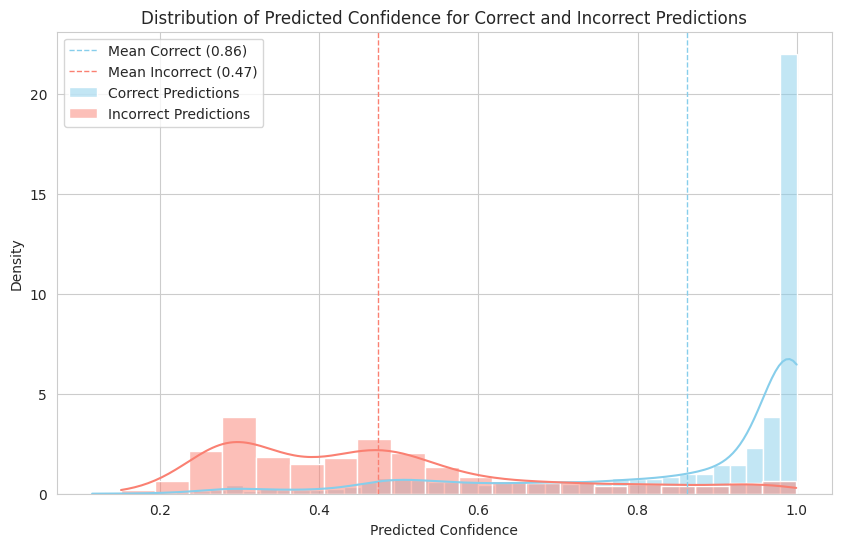


💥 STARTING EVALUATION: Lnew 💥
--- Evaluating Conviction System ---
Base Predictor Accuracy: 83.93%
AUROC for Failure Prediction: 0.8986
AUPRC for Failure Prediction: 0.5897
Mean Confidence (Correct): 0.7667
Mean Confidence (Incorrect): 0.2302


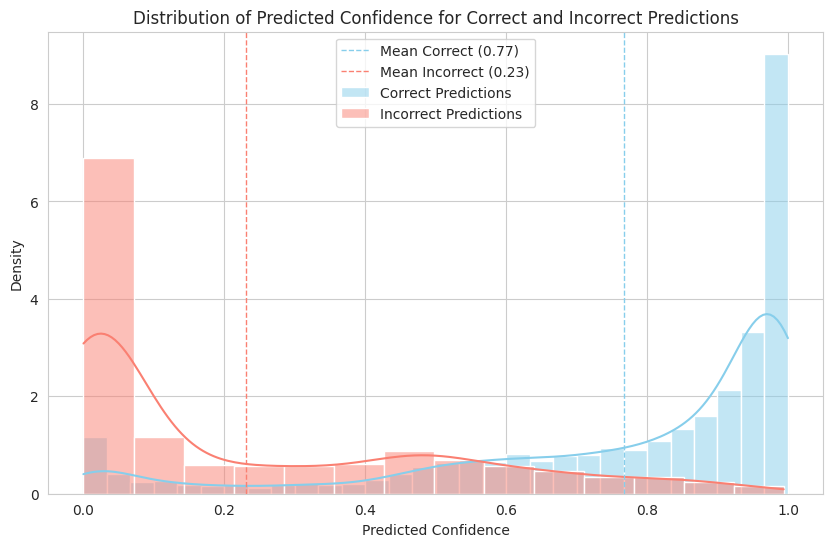


--- 📊 Final Metrics Comparison ---


,accuracy,auroc,auprc,mean_conf_correct,mean_conf_incorrect
Fine-Tuned (MSE),88.06,0.913828,0.578474,0.866988,0.425985
Fine-Tuned (L_new),83.93,0.898620,0.589725,0.766695,0.230196


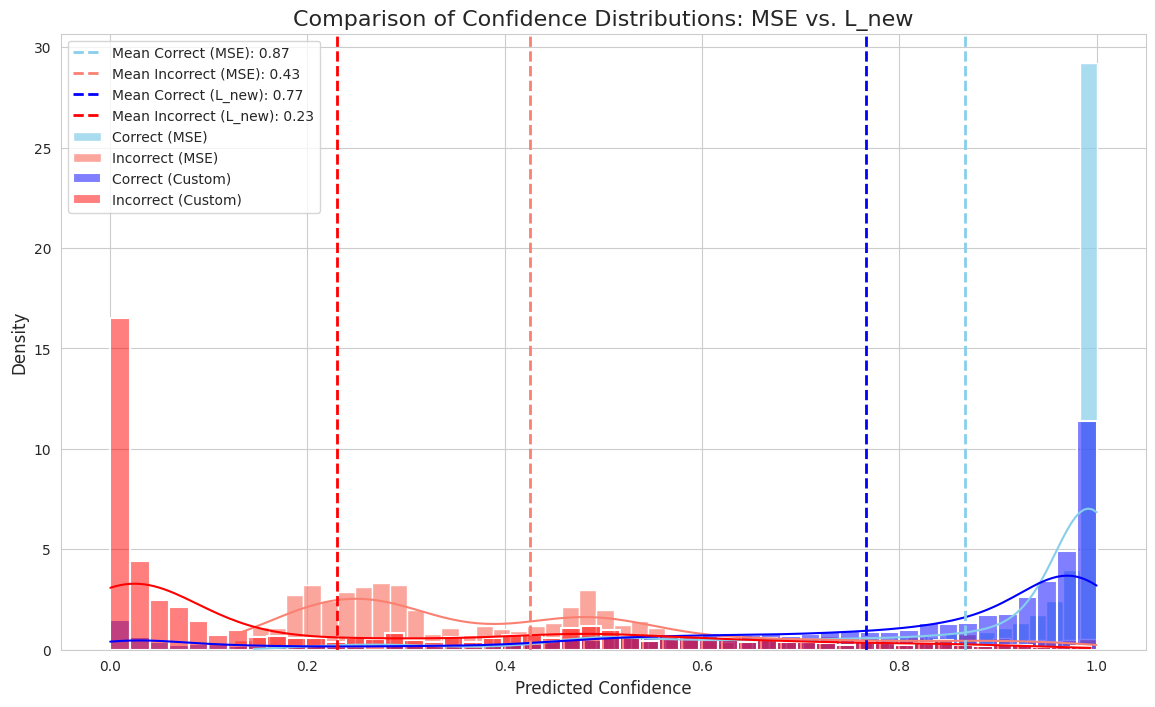

In [ ]:
# --- Model Selection ---
predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
#predictor = SimpleConvPredictor(num_classes=NUM_CLASSES)

# The conviction network's input must match the predictor's feature dimension
conviction_net = MLPConvictionNet(input_dim=predictor.feature_dim)

# File paths for saving models
predictor_path = MODELS_DIR / f"{predictor.__class__.__name__}.pth"
# Corrected conviction_path to save the conviction network trained in Stage 2 correctly
conviction_path = MODELS_DIR / f"{conviction_net.__class__.__name__}.pth"
#predictor_path = Path(f"models/{predictor.__class__.__name__}.pth")
#conviction_path = Path(f"models/{conviction_net.__class__.__name__}_on_{predictor.__class__.__name__}.pth")
finetuned_path = Path(f"models/finetuned_combined_model.pth")



# --- Get Data ---
train_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE)

# --- STAGE 1: Train the Predictor (run only if model file doesn't exist) ---
if not predictor_path.exists():
  train_predictor(model=predictor,
                  train_loader=train_loader,
                  epochs=EPOCHS_PREDICTOR,
                  lr=LR_PREDICTOR,
                  device=DEVICE,
                  model_save_path=predictor_path)
else:
  print(f"--- Stage 1: Found existing predictor at {predictor_path}, skipping training. ---")
  # Load the trained predictor
  predictor.load_state_dict(torch.load(predictor_path))

# --- STAGE 2: Train the Conviction Network (run only if model file doesn't exist) ---
if not conviction_path.exists():
  # Prepare the specialized dataset for the conviction network
  conviction_train_loader = prepare_conviction_data(predictor, train_loader, DEVICE)
  # Train the conviction network with the predictor's weights frozen
  train_conviction_network(
      model=conviction_net,
      train_loader=conviction_train_loader,
      epochs=EPOCHS_CONVICTION,
      lr=LR_CONVICTION,
      device=DEVICE,
      model_save_path=conviction_path,
      stage_name="Stage 2: Training Conviction Network (Frozen Predictor)",
      #loss_fn=WeightedSumLoss()
      )
else:
  print(f"--- Stage 2: Found existing conviction net at {conviction_path}, skipping training. ---")


# 2. Define paths to the base models created in Stages 1 & 2
base_predictor_name = VGGStylePredictor(num_classes=NUM_CLASSES).__class__.__name__
base_conviction_name = MLPConvictionNet(input_dim=VGGStylePredictor().feature_dim).__class__.__name__
base_paths = {
    'predictor': Path(f"models/{base_predictor_name}.pth"),
    # Corrected base_paths['conviction'] to match the corrected save path in Stage 2
    'conviction': Path(f"models/{base_conviction_name}.pth")
}

# 3. Ensure base models exist before running
if not base_paths['predictor'].exists() or not base_paths['conviction'].exists():
    print("‼️ Base models not found! Please run the cells for Stage 1 and Stage 2 first.")
else:
    # 4. Run both experiments
    mse_results, mse_confidences, mse_correctness = run_experiment('MSE', config, base_paths, (train_loader, test_loader), verbose=True)
    lnew_results, lnew_confidences, lnew_correctness = run_experiment('L_new', config, base_paths, (train_loader, test_loader))



    ######################### TEST MSE
    # --- STAGE 4: Final Evaluation ---
    print(f"\n{'='*30}\n💥 STARTING EVALUATION: MSE 💥\n{'='*30}")

    finetuned_path = Path(f"models/finetuned_model_MSE.pth")
    # Load the original predictor for calculating accuracy
    #final_predictor = SimpleConvPredictor(num_classes=NUM_CLASSES) # Use the same class as trained
    final_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    final_predictor.load_state_dict(torch.load(predictor_path))
    final_predictor.eval().to(DEVICE) # Ensure predictor is on the correct device for evaluation

    # Load the fine-tuned conviction network directly
    final_conviction_net = MLPConvictionNet(input_dim=final_predictor.feature_dim)
    # Load the state dict of the conviction network from the saved combined model state dict
    combined_model_state_dict = torch.load(finetuned_path)
    # Extract the state dict for the conviction network part
    conviction_net_state_dict = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict.items() if 'conviction_network.' in k}
    final_conviction_net.load_state_dict(conviction_net_state_dict)
    final_conviction_net.eval().to(DEVICE) # Ensure conviction net is on the correct device


    results, confidences, correctness = evaluate_conviction_system(
        predictor=final_predictor,
        conviction_model=final_conviction_net, # Pass the fine-tuned conviction net
        test_loader=test_loader,
        device=DEVICE,
        verbose=True
    )

    # --- STAGE 5: Visualize Results ---
    plot_confidence_distribution(confidences, correctness, title=f"Confidence on {predictor.__class__.__name__} (Fine-tuned MSE)")


    ########################### TEST Lnew
    print(f"\n{'='*30}\n💥 STARTING EVALUATION: Lnew 💥\n{'='*30}")

    finetuned_path = Path(f"models/finetuned_model_L_new.pth")
    # Load the original predictor for calculating accuracy
    #final_predictor = SimpleConvPredictor(num_classes=NUM_CLASSES) # Use the same class as trained
    final_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    final_predictor.load_state_dict(torch.load(predictor_path))
    final_predictor.eval().to(DEVICE) # Ensure predictor is on the correct device for evaluation

    # Load the fine-tuned conviction network directly
    final_conviction_net = MLPConvictionNet(input_dim=final_predictor.feature_dim)
    # Load the state dict of the conviction network from the saved combined model state dict
    combined_model_state_dict = torch.load(finetuned_path)
    # Extract the state dict for the conviction network part
    conviction_net_state_dict = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict.items() if 'conviction_network.' in k}
    final_conviction_net.load_state_dict(conviction_net_state_dict)
    final_conviction_net.eval().to(DEVICE) # Ensure conviction net is on the correct device

    lnew_results, lnew_confidences, lnew_correctness = evaluate_conviction_system(
        predictor=final_predictor,
        conviction_model=final_conviction_net, # Pass the fine-tuned conviction net
        test_loader=test_loader,
        device=DEVICE,
        verbose=True
    )

    # --- STAGE 5: Visualize Results ---
    plot_confidence_distribution(lnew_confidences, lnew_correctness, title=f"Confidence on {predictor.__class__.__name__} (Fine-tuned Lnew)")

    #############################

    # 5. Create and Display Comparison DataFrame
    comparison_df = pd.DataFrame([mse_results, lnew_results], index=["Fine-Tuned (MSE)", "Fine-Tuned (L_new)"])
    print("\n--- 📊 Final Metrics Comparison ---")
    display(comparison_df)
    # 6. Create Combined Visualization
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    plt.title("Comparison of Confidence Distributions: MSE vs. L_new", fontsize=16)
    # Plot for MSE (filled histograms)
    sns.histplot(mse_confidences[mse_correctness == 1], color='skyblue', label='Correct (MSE)', kde=True, stat='density', alpha=0.7, bins=50)
    sns.histplot(mse_confidences[mse_correctness == 0], color='salmon', label='Incorrect (MSE)', kde=True, stat='density', alpha=0.7, bins=50)
    sns.histplot(lnew_confidences[lnew_correctness == 1], color='blue', label='Correct (Custom)', kde=True, stat='density', common_norm=False, linewidth=1.5, bins=50)
    sns.histplot(lnew_confidences[lnew_correctness == 0], color='red', label='Incorrect (Custom)', kde=True, stat='density', common_norm=False, linewidth=1.5, bins=50)


    # Plot for L_new (overlayed density lines for clarity)
    #sns.kdeplot(lnew_confidences[lnew_correctness == 1], color='blue', label='Correct (L_new)', linewidth=2.5, fill=True, alpha=0.1)
    #sns.kdeplot(lnew_confidences[lnew_correctness == 0], color='red', label='Incorrect (L_new)', linewidth=2.5, fill=True, alpha=0.1)

    # Add vertical lines for mean confidences
    plt.axvline(comparison_df.loc['Fine-Tuned (MSE)', 'mean_conf_correct'], color='skyblue', linestyle='dashed', linewidth=2, label=f"Mean Correct (MSE): {comparison_df.loc['Fine-Tuned (MSE)', 'mean_conf_correct']:.2f}")
    plt.axvline(comparison_df.loc['Fine-Tuned (MSE)', 'mean_conf_incorrect'], color='salmon', linestyle='dashed', linewidth=2, label=f"Mean Incorrect (MSE): {comparison_df.loc['Fine-Tuned (MSE)', 'mean_conf_incorrect']:.2f}")
    plt.axvline(comparison_df.loc['Fine-Tuned (L_new)', 'mean_conf_correct'], color='blue', linestyle='dashed', linewidth=2, label=f"Mean Correct (L_new): {comparison_df.loc['Fine-Tuned (L_new)', 'mean_conf_correct']:.2f}")
    plt.axvline(comparison_df.loc['Fine-Tuned (L_new)', 'mean_conf_incorrect'], color='red', linestyle='dashed', linewidth=2, label=f"Mean Incorrect (L_new): {comparison_df.loc['Fine-Tuned (L_new)', 'mean_conf_incorrect']:.2f}")

    plt.xlabel("Predicted Confidence", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.show()

#3. Test and evaluations

In [ ]:
import requests
from PIL import Image
import io

# List of 25 CIFAR-10 sample image URLs
image_urls = [
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer5.png"
]

downloaded_images = []
for url in image_urls:
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    downloaded_images.append(image)

print(f"{len(downloaded_images)} images have been downloaded successfully.")

25 images have been downloaded successfully.


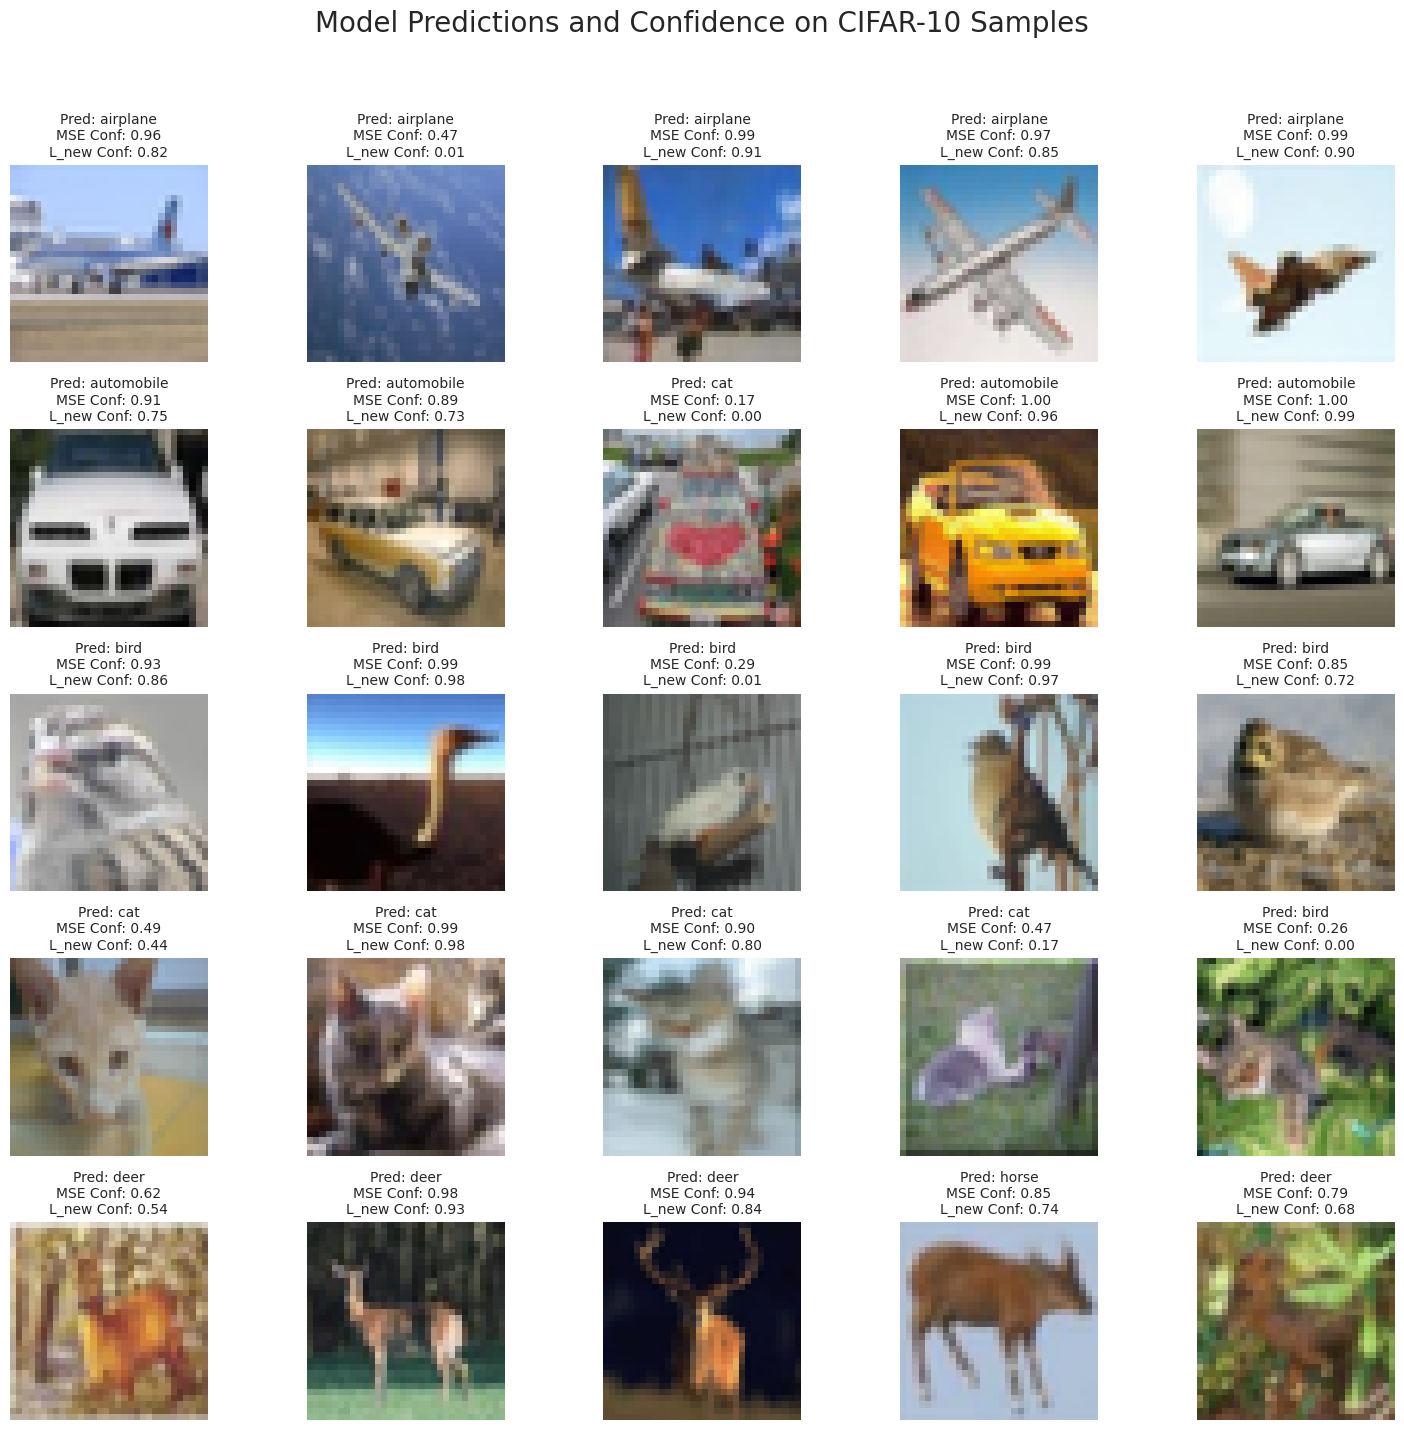

In [ ]:
# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models
# MSE Model
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
final_predictor_mse.load_state_dict(torch.load(predictor_path))
final_predictor_mse.eval().to(DEVICE)
final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
combined_model_state_dict_mse = torch.load(finetuned_path_mse)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)

# L_new Model
finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
final_predictor_lnew.load_state_dict(torch.load(predictor_path))
final_predictor_lnew.eval().to(DEVICE)
final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)

def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image."""
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

# Create the 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Model Predictions and Confidence on CIFAR-10 Samples', fontsize=20)

for i, image in enumerate(downloaded_images):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)

    # Get predictions from both models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)

    ax.set_title(f"Pred: {pred_class_mse}\n"
                 f"MSE Conf: {conf_mse:.2f}\n"
                 f"L_new Conf: {conf_lnew:.2f}",
                 fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Error downloading https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2: 404 Client Error: Not Found for url: https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2
9 images have been downloaded successfully.


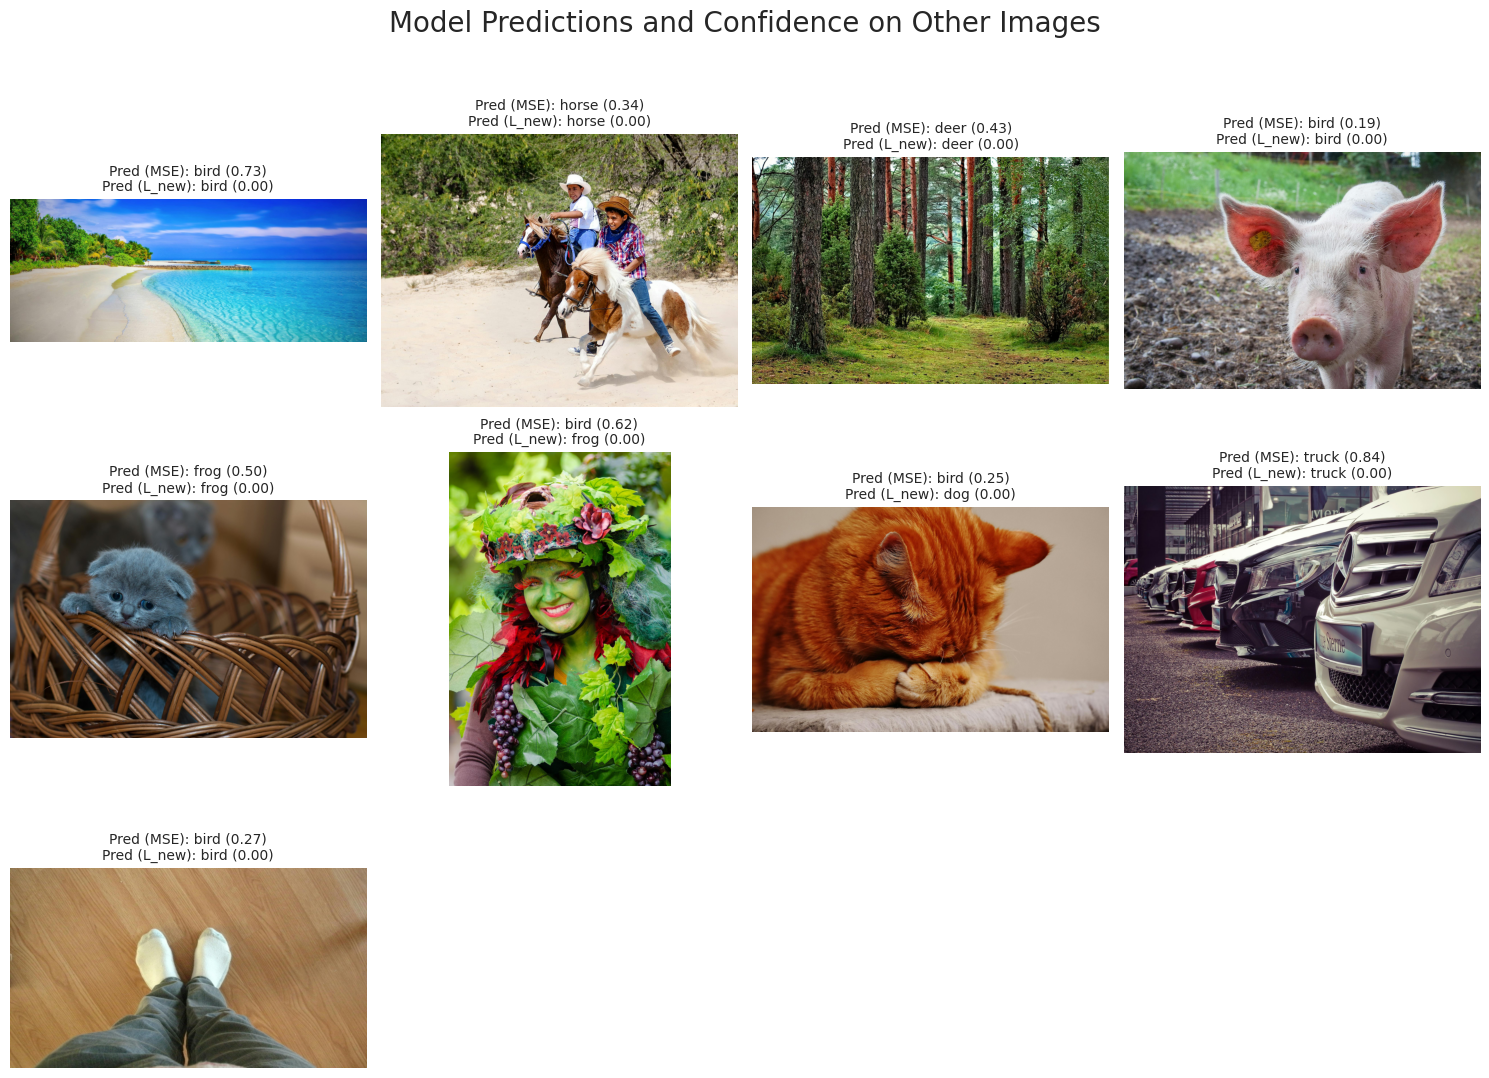

In [ ]:
# Define URLs for sample images not from CIFAR-10
# These are diverse images to see how the model generalizes
other_image_urls = [
    "https://images.pexels.com/photos/248797/pexels-photo-248797.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Beach
    "https://images.pexels.com/photos/132068/pexels-photo-132068.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Mountain
    "https://images.pexels.com/photos/302804/pexels-photo-302804.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Coffee
    "https://images.pexels.com/photos/110820/pexels-photo-110820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Dog
    "https://images.pexels.com/photos/127027/pexels-photo-127027.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cat
    "https://images.pexels.com/photos/145934/pexels-photo-145934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Bird
    "https://images.pexels.com/photos/209037/pexels-photo-209037.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Car
    "https://images.pexels.com/photos/164634/pexels-photo-164634.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Truck
    "https://images.pexels.com/photos/1000365/pexels-photo-1000365.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Ship
    "https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Airplane
]

downloaded_other_images = []
for url in other_image_urls:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        image = Image.open(io.BytesIO(response.content)).convert("RGB") # Ensure image is in RGB
        downloaded_other_images.append(image)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")


print(f"{len(downloaded_other_images)} images have been downloaded successfully.")

# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models (assuming they are saved from the previous step)
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_mse = torch.load(finetuned_path_mse, map_location=DEVICE)
predictor_state_dict_mse = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_mse.items() if 'predictor_model.' in k}
final_predictor_mse.load_state_dict(predictor_state_dict_mse)
final_predictor_mse.eval().to(DEVICE)

final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)


finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew, map_location=DEVICE)
predictor_state_dict_lnew = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'predictor_model.' in k}
final_predictor_lnew.load_state_dict(predictor_state_dict_lnew)
final_predictor_lnew.eval().to(DEVICE)

final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)


# Function to predict class and confidence for a single image
def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image."""
    # Resize the image to 32x32 to match CIFAR-10 input size
    image = image.resize((32, 32))
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

# Determine grid size (e.g., 3x4 for 10 images)
n_images = len(downloaded_other_images)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Model Predictions and Confidence on Other Images', fontsize=20)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, image in enumerate(downloaded_other_images):
    ax = axes[i]
    ax.imshow(image)

    # Get predictions from both models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)

    ax.set_title(f"Pred (MSE): {pred_class_mse} ({conf_mse:.2f})\n"
                 f"Pred (L_new): {pred_class_lnew} ({conf_lnew:.2f})",
                 fontsize=10)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Error downloading https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2: 404 Client Error: Not Found for url: https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2
24 images have been downloaded and resized successfully.


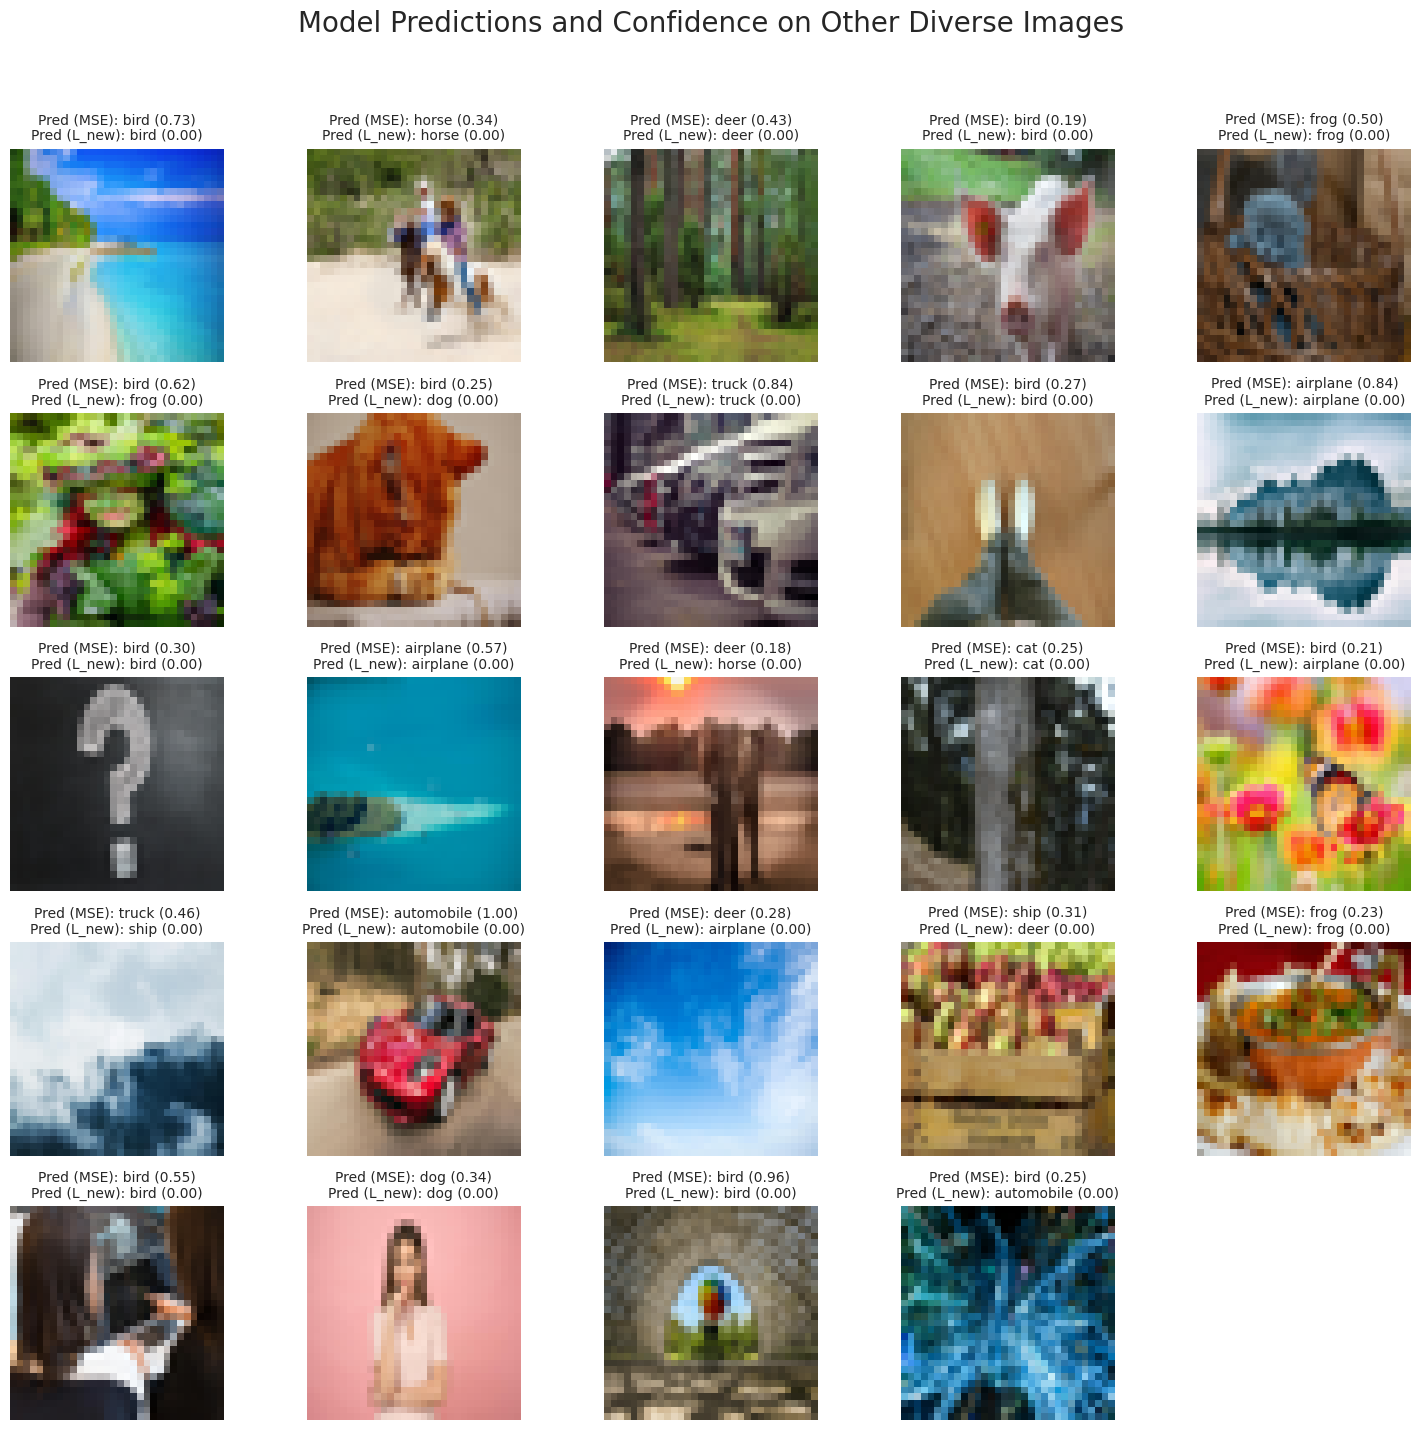

In [ ]:
# Define URLs for a new set of 25 diverse images (not from CIFAR-10)
# These are diverse images to see how the model generalizes
# Let's use a mix of image categories.
other_image_urls_25 = [
    "https://images.pexels.com/photos/248797/pexels-photo-248797.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Beach
    "https://images.pexels.com/photos/132068/pexels-photo-132068.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Mountain
    "https://images.pexels.com/photos/302804/pexels-photo-302804.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Coffee
    "https://images.pexels.com/photos/110820/pexels-photo-110820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Dog
    "https://images.pexels.com/photos/127027/pexels-photo-127027.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cat
    "https://images.pexels.com/photos/145934/pexels-photo-145934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Bird
    "https://images.pexels.com/photos/209037/pexels-photo-209037.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Car
    "https://images.pexels.com/photos/164634/pexels-photo-164634.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Truck
    "https://images.pexels.com/photos/1000365/pexels-photo-1000365.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Ship
    "https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Airplane
    "https://images.pexels.com/photos/459225/pexels-photo-459225.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Forest
    "https://images.pexels.com/photos/356079/pexels-photo-356079.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Horse
    "https://images.pexels.com/photos/1528411/pexels-photo-1528411.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Deer
    "https://images.pexels.com/photos/1054655/pexels-photo-1054655.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Frog
    "https://images.pexels.com/photos/1334918/pexels-photo-1334918.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Flower
    "https://images.pexels.com/photos/462118/pexels-photo-462118.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Library
    "https://images.pexels.com/photos/167699/pexels-photo-167699.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Building
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cityscape
    "https://images.pexels.com/photos/912110/pexels-photo-912110.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Person
    "https://images.pexels.com/photos/265362/pexels-photo-265362.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Food
    "https://images.pexels.com/photos/2474661/pexels-photo-2474661.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Abstract
    "https://images.pexels.com/photos/1181263/pexels-photo-1181263.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Laptop
    "https://images.pexels.com/photos/1036623/pexels-photo-1036623.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Music
    "https://images.pexels.com/photos/355874/pexels-photo-355874.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Space
    "https://images.pexels.com/photos/373543/pexels-photo-373543.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"  # Art
]


downloaded_other_images_25 = []
for url in other_image_urls_25:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        image = Image.open(io.BytesIO(response.content)).convert("RGB") # Ensure image is in RGB
        # Resize the image to 32x32 to match CIFAR-10 input size
        image = image.resize((32, 32))
        downloaded_other_images_25.append(image)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")


print(f"{len(downloaded_other_images_25)} images have been downloaded and resized successfully.")

# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models (assuming they are saved from the previous step)
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_mse = torch.load(finetuned_path_mse, map_location=DEVICE)
predictor_state_dict_mse = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_mse.items() if 'predictor_model.' in k}
final_predictor_mse.load_state_dict(predictor_state_dict_mse)
final_predictor_mse.eval().to(DEVICE)

final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)


finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew, map_location=DEVICE)
predictor_state_dict_lnew = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'predictor_model.' in k}
final_predictor_lnew.load_state_dict(predictor_state_dict_lnew)
final_predictor_lnew.eval().to(DEVICE)

final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)


# Function to predict class and confidence for a single image
def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image."""
    # The image is already resized to 32x32 during download
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

# Create the 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Model Predictions and Confidence on Other Diverse Images', fontsize=20)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, image in enumerate(downloaded_other_images_25):
    ax = axes[i]
    ax.imshow(image)

    # Get predictions from both models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)

    ax.set_title(f"Pred (MSE): {pred_class_mse} ({conf_mse:.2f})\n"
                 f"Pred (L_new): {pred_class_lnew} ({conf_lnew:.2f})",
                 fontsize=10)
    ax.axis('off')

# Hide any unused subplots (shouldn't be any with 25 images in a 5x5 grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#                     accuracy     auroc     auprc  mean_conf_correct  mean_conf_incorrect
# Fine-Tuned (MSE)       85.17  0.902578  0.590752           0.868726             0.479288
# Fine-Tuned (L_new)     85.17  0.899625  0.582576           0.788549             0.253872

In [ ]:
upload_models_to_drive(source_folder=Path("models"), destination_folder=Path("/content/drive/MyDrive/colab_model_backups/notebook_2"))


✅ Successfully copied 'models' to '/content/drive/MyDrive/colab_model_backups/notebook_2/models'


In [ ]:
# ==========================================================================================
# 6. Calibration Metrics (ECE)
# ==========================================================================================

def calculate_ece(confidences, correctness, n_bins=10):
    """
    Calculates the Expected Calibration Error (ECE).

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (between 0 and 1).
        correctness (np.ndarray): Array of booleans indicating whether the prediction was correct.
        n_bins (int): The number of bins to use for the reliability diagram.

    Returns:
        float: The calculated ECE.
    """
    if len(confidences) != len(correctness):
        raise ValueError("Confidence and correctness arrays must have the same length.")

    # Create bins based on confidence scores
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        # Define the range for the current bin
        bin_start = bins[i]
        bin_end = bins[i+1]

        # Find indices of predictions falling into the current bin
        if i == n_bins - 1:
            # Include the upper bound in the last bin
            bin_indices = np.where((confidences >= bin_start) & (confidences <= bin_end))[0]
        else:
            bin_indices = np.where((confidences >= bin_start) & (confidences < bin_end))[0]

        # If the bin is not empty
        if len(bin_indices) > 0:
            # Calculate average confidence and accuracy for the bin
            bin_confidences = confidences[bin_indices]
            bin_correctness = correctness[bin_indices]

            avg_confidence = np.mean(bin_confidences)
            avg_accuracy = np.mean(bin_correctness)

            # Calculate the absolute difference between average confidence and accuracy
            abs_diff = np.abs(avg_confidence - avg_accuracy)

            # Calculate the proportion of samples in the bin
            bin_proportion = len(bin_indices) / len(confidences)

            # Add to the ECE
            ece += abs_diff * bin_proportion

    return ece

In [ ]:
# Update the evaluation part in the main execution cell to include ECE

# Assume the run_experiment function has been executed and results are stored in:
# mse_results, mse_confidences, mse_correctness
# lnew_results, lnew_confidences, lnew_correctness

# Calculate ECE for both models
ece_mse = calculate_ece(mse_confidences, mse_correctness)
ece_lnew = calculate_ece(lnew_confidences, lnew_correctness)

print(f"\n--- Expected Calibration Error (ECE) ---")
print(f"Fine-Tuned (MSE) ECE: {ece_mse:.4f}")
print(f"Fine-Tuned (L_new) ECE: {ece_lnew:.4f}")

# Update the comparison DataFrame
comparison_df['ece'] = [ece_mse, ece_lnew]

print("\n--- 📊 Final Metrics Comparison (with ECE) ---")
display(comparison_df)


--- Expected Calibration Error (ECE) ---
Fine-Tuned (MSE) ECE: 0.0663
Fine-Tuned (L_new) ECE: 0.1588

--- 📊 Final Metrics Comparison (with ECE) ---


,accuracy,auroc,auprc,mean_conf_correct,mean_conf_incorrect,ece
Fine-Tuned (MSE),88.06,0.913828,0.578474,0.866988,0.425985,0.066268
Fine-Tuned (L_new),83.93,0.898620,0.589725,0.766695,0.230196,0.158820


## Reliability diagrams function



In [ ]:
def plot_reliability_diagram(confidences, correctness, n_bins=10, title="Reliability Diagram"):
    """
    Plots a reliability diagram to visualize model calibration.

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (between 0 and 1).
        correctness (np.ndarray): Array of booleans indicating whether the prediction was correct.
        n_bins (int): The number of bins to use for the reliability diagram.
        title (str): The title of the plot.
    """
    if len(confidences) != len(correctness):
        raise ValueError("Confidence and correctness arrays must have the same length.")

    # Create bins based on confidence scores
    bins = np.linspace(0, 1, n_bins + 1)
    avg_confidences = []
    avg_accuracies = []

    for i in range(n_bins):
        # Define the range for the current bin
        bin_start = bins[i]
        bin_end = bins[i+1]

        # Find indices of predictions falling into the current bin
        if i == n_bins - 1:
            # Include the upper bound in the last bin
            bin_indices = np.where((confidences >= bin_start) & (confidences <= bin_end))[0]
        else:
            bin_indices = np.where((confidences >= bin_start) & (confidences < bin_end))[0]

        # If the bin is not empty
        if len(bin_indices) > 0:
            # Calculate average confidence and accuracy for the bin
            bin_confidences = confidences[bin_indices]
            bin_correctness = correctness[bin_indices]

            avg_confidence = np.mean(bin_confidences)
            avg_accuracy = np.mean(bin_correctness)

            avg_confidences.append(avg_confidence)
            avg_accuracies.append(avg_accuracy)

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.scatter(avg_confidences, avg_accuracies, marker='o', color='blue', label='Model Calibration')

    plt.xlabel("Average Predicted Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.show()

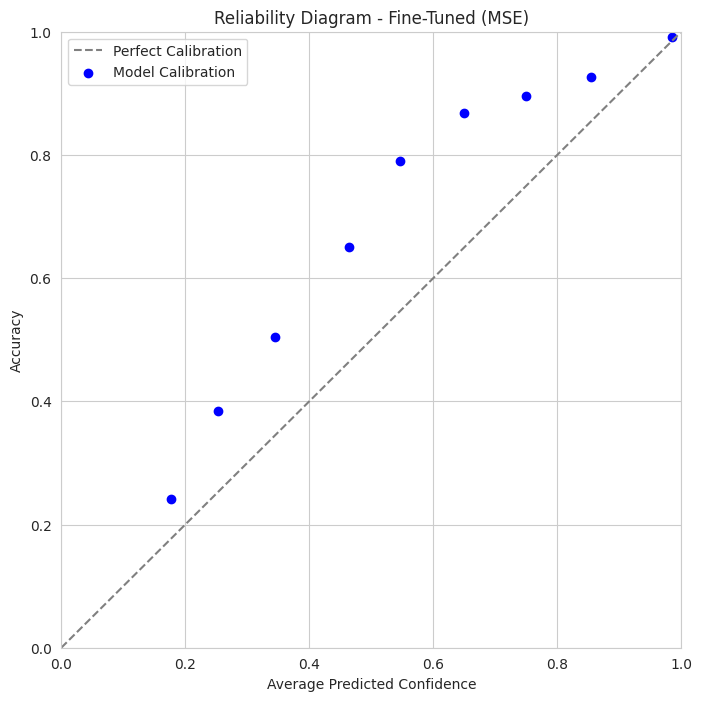

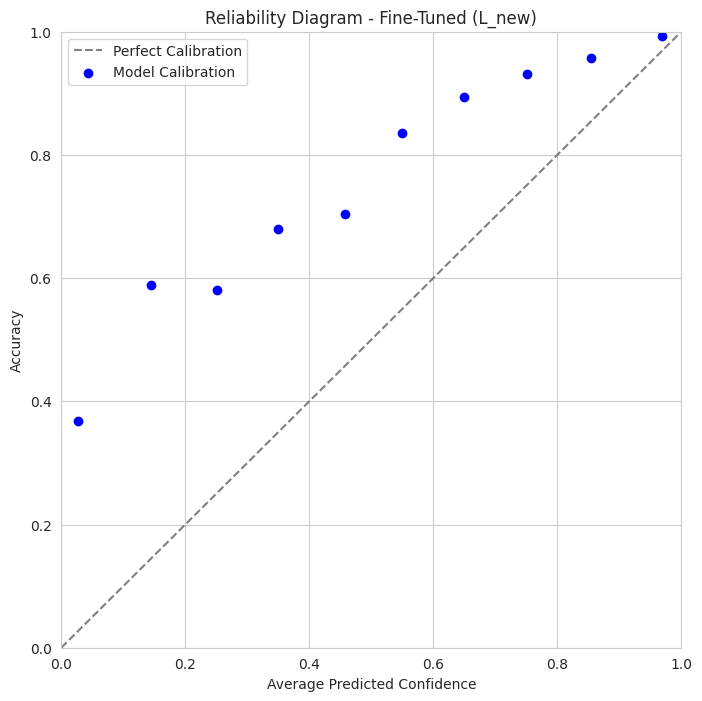

In [ ]:
plot_reliability_diagram(mse_confidences, mse_correctness, title="Reliability Diagram - Fine-Tuned (MSE)")
plot_reliability_diagram(lnew_confidences, lnew_correctness, title="Reliability Diagram - Fine-Tuned (L_new)")